In [29]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from PIL import Image

In [30]:
(x_train,_),(x_test,_)=tf.keras.datasets.mnist.load_data()

In [31]:
# add one more dimension and make the number between 0-1 (divided by 255)
x_train=np.expand_dims(x_train,-1).astype('float32')/255
x_test=np.expand_dims(x_test,-1).astype('float32')/255

In [32]:
x_train_dataset=tf.data.Dataset.from_tensor_slices(x_train)

In [33]:
# let's shuffle and batch our dataset
batch_size=64
buffer_size=1000
train_dataset=x_train_dataset.shuffle(buffer_size=batch_size*buffer_size, reshuffle_each_iteration=True).batch(batch_size,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

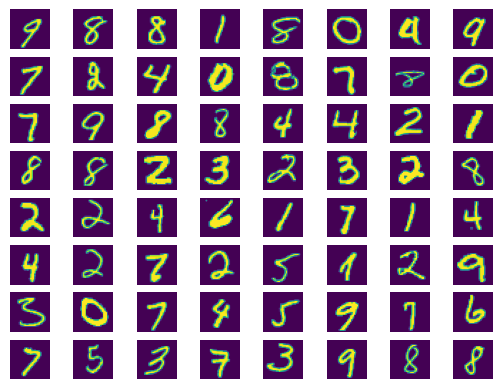

In [34]:
first_batch=iter(train_dataset).get_next()
k=1
while k<65:
    ax=plt.subplot(8,8,k)
    plt.imshow(first_batch[k-1])
    plt.axis('off')
    k+=1

### Encoder

In [35]:
class Sampling(Layer):
    def call(self,inputs):
        mean,log_var=inputs
        return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape=(tf.shape(mean)[0],tf.shape(mean)[1]))

In [36]:
latent_dim=100

In [37]:
encoder_inputs=Input(shape=(28,28,1))
x=Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
x=Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
x=Flatten()(x)
x=Dense(16,activation='relu')(x)
mean=Dense(latent_dim,)(x)
log_var=Dense(latent_dim,)(x)
z=Sampling()([mean,log_var])
encoder_model=Model(encoder_inputs,[z,mean,log_var],name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

### Decoder

In [38]:
latent_inputs=Input(shape=(latent_dim,))
x=Dense(7*7*64,activation='relu')(latent_inputs)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x=Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
decoder_outputs=Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)
decoder_model=Model(latent_inputs,decoder_outputs,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              316736    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 372,417
Trainable params: 372,417
Non-trainable params: 0
_____________________________________________________

### Overall VAE Model

In [39]:
vae_input=Input(shape=(28,28,1),name='vae_input')
z,_,_=encoder_model(vae_input)
output=decoder_model(z)
vae=Model(vae_input,output,name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vae_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 100), (None, 100) 72408     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         372417    
Total params: 444,825
Trainable params: 444,825
Non-trainable params: 0
_________________________________________________________________


In [40]:
vae.layers

In [41]:
def custom_loss(y_true,y_pred,mean,log_var):
    loss_recons=tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis=(1,2)))
    loss_reg=tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)),axis=1))
    return loss_recons+loss_reg

In [42]:
OPTIMIZER=Adam(learning_rate=1e-3)

In [43]:
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z,mean,log_var=encoder_model(x_batch)
        y_pred=decoder_model(z)
        y_true=x_batch
        loss=custom_loss(y_true,y_pred,mean,log_var)
    partial_derivatives=recorder.gradient(loss,vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives,vae.trainable_weights))
    return loss

In [44]:
def neuralearn(epochs):
    for epoch in range(1,epochs+1):
        print(f'Training starts for epochs number {epoch}')
        for step,x_batch in enumerate(train_dataset):
            loss=training_block(x_batch)
        print('Training loss is:',loss)
    print('Training Complete!')

In [45]:
neuralearn(20)

Training starts for epochs number 1
Training loss is: tf.Tensor(165.0224, shape=(), dtype=float32)
Training starts for epochs number 2
Training loss is: tf.Tensor(153.71896, shape=(), dtype=float32)
Training starts for epochs number 3
Training loss is: tf.Tensor(138.00769, shape=(), dtype=float32)
Training starts for epochs number 4
Training loss is: tf.Tensor(135.88641, shape=(), dtype=float32)
Training starts for epochs number 5
Training loss is: tf.Tensor(136.95438, shape=(), dtype=float32)
Training starts for epochs number 6
Training loss is: tf.Tensor(126.548164, shape=(), dtype=float32)
Training starts for epochs number 7
Training loss is: tf.Tensor(122.346466, shape=(), dtype=float32)
Training starts for epochs number 8
Training loss is: tf.Tensor(122.052315, shape=(), dtype=float32)
Training starts for epochs number 9
Training loss is: tf.Tensor(126.354744, shape=(), dtype=float32)
Training starts for epochs number 10
Training loss is: tf.Tensor(129.3067, shape=(), dtype=float3

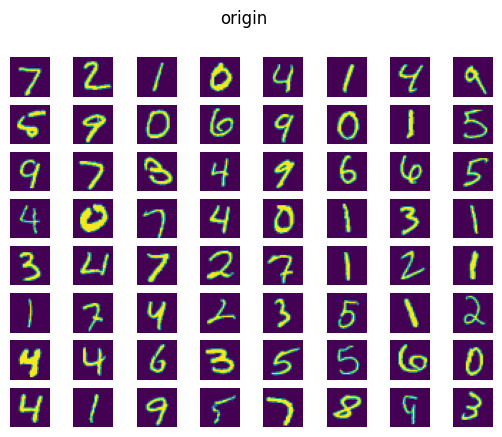

In [46]:
test_dataset=tf.data.Dataset.from_tensor_slices(x_test).batch(64).prefetch(tf.data.AUTOTUNE)
first_batch=iter(test_dataset).get_next()
# original images
k=1
while k<65:
    plt.subplot(8,8,k)
    plt.imshow(first_batch[k-1])
    plt.axis('off')
    k+=1
plt.suptitle('origin')
plt.savefig('vae_origin.png')

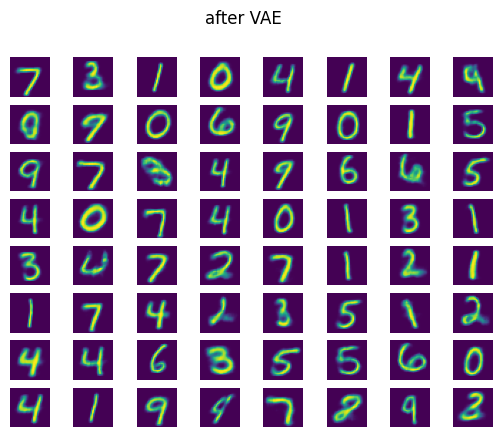

In [47]:
predicted_1batch=vae.predict(first_batch)
k=1
while k<65:
    plt.subplot(8,8,k)
    plt.imshow(predicted_1batch[k-1])
    plt.axis('off')
    k+=1
plt.suptitle('after VAE')
plt.savefig('vae_result.png')

In [48]:
ori=Image.open('vae_origin.png')
after=Image.open('vae_result.png')
images=[ori,after]
ori.save('vae_compare.gif',format='GIF',append_images=images,save_all=True,duration=300,loop=0)

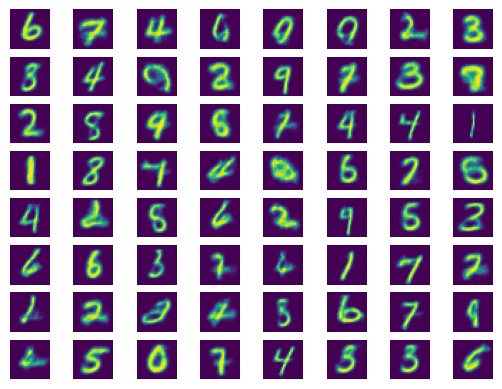

In [49]:
## of course we can use the decoder (vae.layers[2]) as generative model 
# let's generate image from random number sampling from normal distribution
k=1
input_shape=(1,latent_dim)
while k<65:
    plt.subplot(8,8,k)
    input=tf.random.normal(input_shape)
    out=vae.layers[2].predict(input)[0,...]
    plt.imshow(out)
    plt.axis('off')
    k+=1

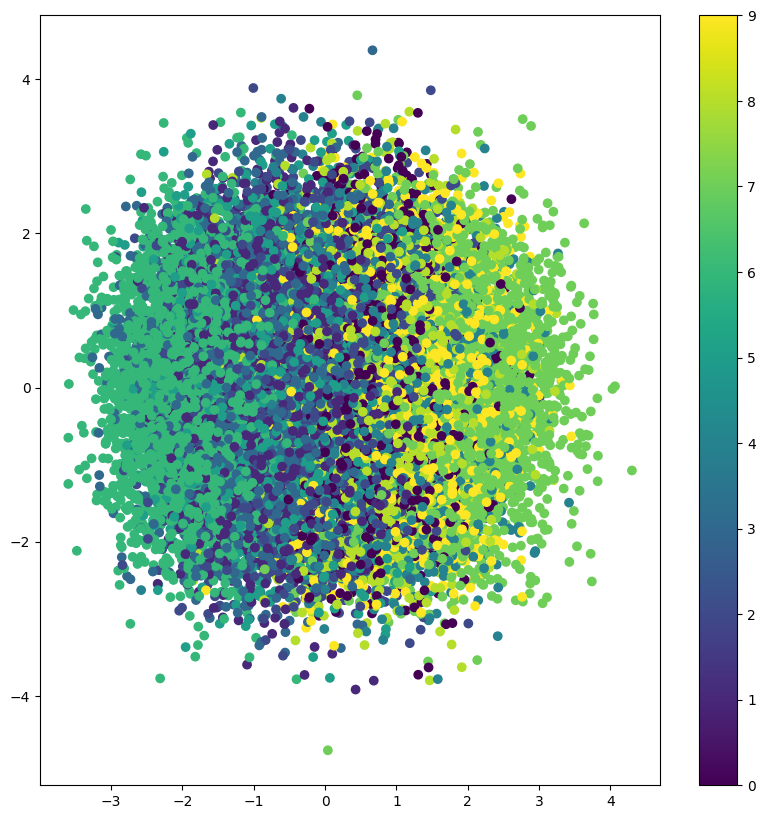

In [79]:
(x_train,y_train),_=tf.keras.datasets.mnist.load_data()
x_train=np.expand_dims(x_train,-1).astype('float32')/255
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(10,10))
plt.scatter(z[:,9],z[:,99],c=y_train)
plt.colorbar()
plt.show()

In [91]:
def euclidean_distance(v1,v2):
    return np.sqrt(np.sum((v1 - v2)**2))
def dot_product(v1,v2):
    return np.dot(v1,v2)

In [85]:
from itertools import combinations
a=list(range(100))
dist_table={}
for i in combinations(a,2):
    idx1,idx2=i
    dist=euclidean_distance(z[:,idx1],z[:,idx2])
    dist_table[f'{idx1}_{idx2}']=dist

In [93]:
max(dist_table), dist_table['9_99']

('9_99', 375.7426)

In [88]:
x=list(range(100))
product_table={}
for i in combinations(a,2):
    idx1,idx2=i
    product=dot_product(z[:,idx1],z[:,idx2])
    product_table[f'{idx1}_{idx2}']=product

In [92]:
max(product_table), product_table['9_99']

('9_99', 28.529472)